In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")

print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set to length 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
train_true_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), -7:].values)
print(train_v.shape)
print(train_v.shape[0]/28)
print(train_true_v.shape)
print(train_true_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
(2520000, 7)
90000.0


In [5]:
# set up test set
test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)
test_true_v = copy.deepcopy(test_df.iloc[:, -7:].values)
print("TCHDL:", test_df.columns.get_loc('TCHDL'))
print(test_v.shape)
print(test_v.shape[0]/28)
print(test_true_v.shape)
print(test_true_v.shape[0]/28)

Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096
TCHDL: 14
(282688, 182)
10096.0
(282688, 7)
10096.0


In [6]:
print(view_1hot_df.columns.get_loc('TCHDL'))
print(test_df.columns.get_loc('TCHDL'))

14
14


In [7]:
def get_mean_TCHDL(train_v):
    mean_tchdl = []
    num_of_inds = train_v.shape[0]//28
    for i in range(num_of_inds):
        ind_v = train_v[(i*28):((i+1)*28), :]
        ind_tchdl = np.mean(ind_v[8:28, 14])
        mean_tchdl.append(ind_tchdl)
    print(len(mean_tchdl)) 
    return np.array([mean_tchdl]).T

In [8]:
def setup_x(scaled_x):
    num_of_inds = scaled_x.shape[0]//28
    print("Number of individuals: ", num_of_inds)

    x_train_list = []
    start_time = time.time()
    for i in range(num_of_inds): 
        ind_train = copy.deepcopy(scaled_x[(i*28):((i+1)*28), :])
        ind_train_x = copy.deepcopy(ind_train[0:8, :]) 
        x_train_list.append(ind_train_x)
    print("Time to build train test data: ", time.time() - start_time)
    return np.array(x_train_list)

In [9]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
#################################
#  x
#################################
scaler_x = StandardScaler()
scaled_train = scaler_x.fit_transform(train_v) 
scaled_test = scaler_x.transform(test_v)
x_train = setup_x(scaled_train)
x_test = setup_x(scaled_test)
#################################
#  y
#################################
scaler_y = StandardScaler()
mean_tchdl_train = get_mean_TCHDL(train_v)

y_train = scaler_y.fit_transform(mean_tchdl_train)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

Number of individuals:  90000
Time to build train test data:  1.3217697143554688
Number of individuals:  10096
Time to build train test data:  0.12401843070983887
90000
(90000, 8, 182)
(10096, 8, 182)
(90000, 1)


9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/1000
 - 3s - loss: 1.3197 - val_loss: 1.2623

Epoch 00001: val_loss improved from inf to 1.26235, saving model to val_weights1.hdf5
Epoch 2/1000
 - 0s - loss: 1.2381 - val_loss: 1.1861

Epoch 00002: val_loss improved from 1.26235 to 1.18614, saving model to val_weights1.hdf5
Epoch 3/1000
 - 0s - loss: 1.1643 - val_loss: 1.1169

Epoch 00003: val_loss improved from 1.18614 to 1.11693, saving model to val_weights1.hdf5
Epoch 4/1000
 - 0s - loss: 1.0974 - val_loss: 1.0540

Epoch 00004: val_loss improved from 1.11693 to 1.05404, saving model to val_weights1.hdf5
Epoch 5/1000
 - 0s - loss: 1.0362 - val_loss: 0.9964

Epoch 00005: val_loss improved from 1.05404 to 0.99637, saving model to val_weights1.hdf5
Epoch 6/1000
 - 0s - loss: 0.9798 - val_loss: 0.9431

Epoch 00006: val_loss improved from 0.99637 to 0.94313, 


Epoch 00053: val_loss improved from 0.41976 to 0.41922, saving model to val_weights1.hdf5
Epoch 54/1000
 - 0s - loss: 0.4115 - val_loss: 0.4187

Epoch 00054: val_loss improved from 0.41922 to 0.41865, saving model to val_weights1.hdf5
Epoch 55/1000
 - 0s - loss: 0.4109 - val_loss: 0.4179

Epoch 00055: val_loss improved from 0.41865 to 0.41788, saving model to val_weights1.hdf5
Epoch 56/1000
 - 0s - loss: 0.4103 - val_loss: 0.4172

Epoch 00056: val_loss improved from 0.41788 to 0.41724, saving model to val_weights1.hdf5
Epoch 57/1000
 - 0s - loss: 0.4097 - val_loss: 0.4169

Epoch 00057: val_loss improved from 0.41724 to 0.41685, saving model to val_weights1.hdf5
Epoch 58/1000
 - 0s - loss: 0.4092 - val_loss: 0.4163

Epoch 00058: val_loss improved from 0.41685 to 0.41634, saving model to val_weights1.hdf5
Epoch 59/1000
 - 0s - loss: 0.4087 - val_loss: 0.4158

Epoch 00059: val_loss improved from 0.41634 to 0.41575, saving model to val_weights1.hdf5
Epoch 60/1000
 - 0s - loss: 0.4082 - va

 - 0s - loss: 0.3948 - val_loss: 0.4032

Epoch 00116: val_loss did not improve from 0.40304
Epoch 117/1000
 - 0s - loss: 0.3946 - val_loss: 0.4030

Epoch 00117: val_loss improved from 0.40304 to 0.40296, saving model to val_weights1.hdf5
Epoch 118/1000
 - 0s - loss: 0.3943 - val_loss: 0.4033

Epoch 00118: val_loss did not improve from 0.40296
Epoch 119/1000
 - 0s - loss: 0.3943 - val_loss: 0.4033

Epoch 00119: val_loss did not improve from 0.40296
Epoch 120/1000
 - 0s - loss: 0.3942 - val_loss: 0.4027

Epoch 00120: val_loss improved from 0.40296 to 0.40270, saving model to val_weights1.hdf5
Epoch 121/1000
 - 0s - loss: 0.3940 - val_loss: 0.4024

Epoch 00121: val_loss improved from 0.40270 to 0.40235, saving model to val_weights1.hdf5
Epoch 122/1000
 - 0s - loss: 0.3937 - val_loss: 0.4020

Epoch 00122: val_loss improved from 0.40235 to 0.40202, saving model to val_weights1.hdf5
Epoch 123/1000
 - 0s - loss: 0.3935 - val_loss: 0.4023

Epoch 00123: val_loss did not improve from 0.40202
Epo


Epoch 00188: val_loss did not improve from 0.39993
Epoch 189/1000
 - 0s - loss: 0.3895 - val_loss: 0.4007

Epoch 00189: val_loss did not improve from 0.39993
Epoch 190/1000
 - 0s - loss: 0.3895 - val_loss: 0.4006

Epoch 00190: val_loss did not improve from 0.39993
Epoch 191/1000
 - 0s - loss: 0.3894 - val_loss: 0.4002

Epoch 00191: val_loss did not improve from 0.39993
Epoch 192/1000
 - 0s - loss: 0.3892 - val_loss: 0.4001

Epoch 00192: val_loss did not improve from 0.39993
Epoch 193/1000
 - 0s - loss: 0.3891 - val_loss: 0.4001

Epoch 00193: val_loss did not improve from 0.39993
Epoch 194/1000
 - 0s - loss: 0.3890 - val_loss: 0.4005

Epoch 00194: val_loss did not improve from 0.39993
Epoch 195/1000
 - 0s - loss: 0.3890 - val_loss: 0.4010

Epoch 00195: val_loss did not improve from 0.39993
Epoch 196/1000
 - 0s - loss: 0.3891 - val_loss: 0.4005

Epoch 00196: val_loss did not improve from 0.39993
Epoch 197/1000
 - 0s - loss: 0.3892 - val_loss: 0.4000

Epoch 00197: val_loss did not improv


Epoch 00263: val_loss did not improve from 0.39895
Epoch 264/1000
 - 0s - loss: 0.3876 - val_loss: 0.3989

Epoch 00264: val_loss improved from 0.39895 to 0.39885, saving model to val_weights1.hdf5
Epoch 265/1000
 - 0s - loss: 0.3876 - val_loss: 0.3992

Epoch 00265: val_loss did not improve from 0.39885
Epoch 266/1000
 - 0s - loss: 0.3873 - val_loss: 0.3995

Epoch 00266: val_loss did not improve from 0.39885
Epoch 267/1000
 - 0s - loss: 0.3873 - val_loss: 0.3997

Epoch 00267: val_loss did not improve from 0.39885
Epoch 268/1000
 - 0s - loss: 0.3874 - val_loss: 0.3994

Epoch 00268: val_loss did not improve from 0.39885
Epoch 269/1000
 - 0s - loss: 0.3872 - val_loss: 0.3992

Epoch 00269: val_loss did not improve from 0.39885
Epoch 270/1000
 - 0s - loss: 0.3869 - val_loss: 0.3990

Epoch 00270: val_loss did not improve from 0.39885
Epoch 271/1000
 - 0s - loss: 0.3870 - val_loss: 0.3996

Epoch 00271: val_loss did not improve from 0.39885
Epoch 272/1000
 - 0s - loss: 0.3870 - val_loss: 0.399

 - 0s - loss: 0.3860 - val_loss: 0.3986

Epoch 00338: val_loss did not improve from 0.39827
Epoch 339/1000
 - 0s - loss: 0.3860 - val_loss: 0.3986

Epoch 00339: val_loss did not improve from 0.39827
Epoch 340/1000
 - 0s - loss: 0.3860 - val_loss: 0.3992

Epoch 00340: val_loss did not improve from 0.39827
Epoch 341/1000
 - 0s - loss: 0.3860 - val_loss: 0.3994

Epoch 00341: val_loss did not improve from 0.39827
Epoch 342/1000
 - 0s - loss: 0.3862 - val_loss: 0.3992

Epoch 00342: val_loss did not improve from 0.39827
Epoch 343/1000
 - 0s - loss: 0.3866 - val_loss: 0.3984

Epoch 00343: val_loss did not improve from 0.39827
Epoch 344/1000
 - 0s - loss: 0.3865 - val_loss: 0.3987

Epoch 00344: val_loss did not improve from 0.39827
Epoch 345/1000
 - 0s - loss: 0.3861 - val_loss: 0.3990

Epoch 00345: val_loss did not improve from 0.39827
Epoch 346/1000
 - 0s - loss: 0.3861 - val_loss: 0.3993

Epoch 00346: val_loss did not improve from 0.39827
Epoch 347/1000
 - 0s - loss: 0.3862 - val_loss: 0.39

 - 0s - loss: 0.3852 - val_loss: 0.3989

Epoch 00414: val_loss did not improve from 0.39818
Epoch 415/1000
 - 0s - loss: 0.3850 - val_loss: 0.3987

Epoch 00415: val_loss did not improve from 0.39818
Epoch 416/1000
 - 0s - loss: 0.3850 - val_loss: 0.3986

Epoch 00416: val_loss did not improve from 0.39818
Epoch 417/1000
 - 0s - loss: 0.3852 - val_loss: 0.3984

Epoch 00417: val_loss did not improve from 0.39818
Epoch 418/1000
 - 0s - loss: 0.3851 - val_loss: 0.3990

Epoch 00418: val_loss did not improve from 0.39818
Epoch 419/1000
 - 0s - loss: 0.3849 - val_loss: 0.3990

Epoch 00419: val_loss did not improve from 0.39818
Epoch 420/1000
 - 0s - loss: 0.3851 - val_loss: 0.3995

Epoch 00420: val_loss did not improve from 0.39818
Epoch 421/1000
 - 0s - loss: 0.3854 - val_loss: 0.3990

Epoch 00421: val_loss did not improve from 0.39818
Epoch 422/1000
 - 0s - loss: 0.3854 - val_loss: 0.3986

Epoch 00422: val_loss did not improve from 0.39818
Epoch 423/1000
 - 0s - loss: 0.3852 - val_loss: 0.39

 - 0s - loss: 0.3852 - val_loss: 0.3993

Epoch 00491: val_loss did not improve from 0.39818
Epoch 492/1000
 - 0s - loss: 0.3850 - val_loss: 0.3989

Epoch 00492: val_loss did not improve from 0.39818
Epoch 493/1000
 - 0s - loss: 0.3846 - val_loss: 0.3985

Epoch 00493: val_loss did not improve from 0.39818
Epoch 494/1000
 - 0s - loss: 0.3847 - val_loss: 0.3995

Epoch 00494: val_loss did not improve from 0.39818
Epoch 495/1000
 - 0s - loss: 0.3848 - val_loss: 0.3993

Epoch 00495: val_loss did not improve from 0.39818
Epoch 496/1000
 - 0s - loss: 0.3847 - val_loss: 0.3993

Epoch 00496: val_loss did not improve from 0.39818
Epoch 497/1000
 - 0s - loss: 0.3848 - val_loss: 0.3994

Epoch 00497: val_loss did not improve from 0.39818
Epoch 498/1000
 - 0s - loss: 0.3850 - val_loss: 0.3987

Epoch 00498: val_loss did not improve from 0.39818
Epoch 499/1000
 - 0s - loss: 0.3850 - val_loss: 0.3989

Epoch 00499: val_loss did not improve from 0.39818
Epoch 500/1000
 - 0s - loss: 0.3848 - val_loss: 0.39

 - 0s - loss: 0.3840 - val_loss: 0.3991

Epoch 00568: val_loss did not improve from 0.39818
Epoch 569/1000
 - 0s - loss: 0.3844 - val_loss: 0.3993

Epoch 00569: val_loss did not improve from 0.39818
Epoch 570/1000
 - 0s - loss: 0.3842 - val_loss: 0.3991

Epoch 00570: val_loss did not improve from 0.39818
Epoch 571/1000
 - 0s - loss: 0.3839 - val_loss: 0.3993

Epoch 00571: val_loss did not improve from 0.39818
Epoch 572/1000
 - 0s - loss: 0.3837 - val_loss: 0.3991

Epoch 00572: val_loss did not improve from 0.39818
Epoch 573/1000
 - 0s - loss: 0.3838 - val_loss: 0.3993

Epoch 00573: val_loss did not improve from 0.39818
Epoch 574/1000
 - 0s - loss: 0.3840 - val_loss: 0.3989

Epoch 00574: val_loss did not improve from 0.39818
Epoch 575/1000
 - 0s - loss: 0.3839 - val_loss: 0.3992

Epoch 00575: val_loss did not improve from 0.39818
Epoch 576/1000
 - 0s - loss: 0.3837 - val_loss: 0.3995

Epoch 00576: val_loss did not improve from 0.39818
Epoch 577/1000
 - 0s - loss: 0.3838 - val_loss: 0.39

 - 0s - loss: 0.3841 - val_loss: 0.3996

Epoch 00645: val_loss did not improve from 0.39818
Epoch 646/1000
 - 0s - loss: 0.3841 - val_loss: 0.4002

Epoch 00646: val_loss did not improve from 0.39818
Epoch 647/1000
 - 0s - loss: 0.3839 - val_loss: 0.4003

Epoch 00647: val_loss did not improve from 0.39818
Epoch 648/1000
 - 0s - loss: 0.3836 - val_loss: 0.3998

Epoch 00648: val_loss did not improve from 0.39818
Epoch 649/1000
 - 0s - loss: 0.3835 - val_loss: 0.3996

Epoch 00649: val_loss did not improve from 0.39818
Epoch 650/1000
 - 0s - loss: 0.3837 - val_loss: 0.3997

Epoch 00650: val_loss did not improve from 0.39818
Epoch 651/1000
 - 0s - loss: 0.3839 - val_loss: 0.3996

Epoch 00651: val_loss did not improve from 0.39818
Epoch 652/1000
 - 0s - loss: 0.3837 - val_loss: 0.3998

Epoch 00652: val_loss did not improve from 0.39818
Epoch 653/1000
 - 0s - loss: 0.3836 - val_loss: 0.3999

Epoch 00653: val_loss did not improve from 0.39818
Epoch 654/1000
 - 0s - loss: 0.3834 - val_loss: 0.39

 - 0s - loss: 0.3834 - val_loss: 0.3998

Epoch 00722: val_loss did not improve from 0.39818
Epoch 723/1000
 - 0s - loss: 0.3833 - val_loss: 0.3998

Epoch 00723: val_loss did not improve from 0.39818
Epoch 724/1000
 - 0s - loss: 0.3834 - val_loss: 0.3998

Epoch 00724: val_loss did not improve from 0.39818
Epoch 725/1000
 - 0s - loss: 0.3836 - val_loss: 0.3998

Epoch 00725: val_loss did not improve from 0.39818
Epoch 726/1000
 - 0s - loss: 0.3837 - val_loss: 0.3999

Epoch 00726: val_loss did not improve from 0.39818
Epoch 727/1000
 - 0s - loss: 0.3833 - val_loss: 0.4002

Epoch 00727: val_loss did not improve from 0.39818
Epoch 728/1000
 - 0s - loss: 0.3833 - val_loss: 0.4001

Epoch 00728: val_loss did not improve from 0.39818
Epoch 729/1000
 - 0s - loss: 0.3832 - val_loss: 0.3999

Epoch 00729: val_loss did not improve from 0.39818
Epoch 730/1000
 - 0s - loss: 0.3833 - val_loss: 0.3999

Epoch 00730: val_loss did not improve from 0.39818
Epoch 731/1000
 - 0s - loss: 0.3836 - val_loss: 0.39

 - 0s - loss: 0.3833 - val_loss: 0.4008

Epoch 00799: val_loss did not improve from 0.39818
Epoch 800/1000
 - 0s - loss: 0.3835 - val_loss: 0.4002

Epoch 00800: val_loss did not improve from 0.39818
Epoch 801/1000
 - 0s - loss: 0.3834 - val_loss: 0.3998

Epoch 00801: val_loss did not improve from 0.39818
Epoch 802/1000
 - 0s - loss: 0.3831 - val_loss: 0.3996

Epoch 00802: val_loss did not improve from 0.39818
Epoch 803/1000
 - 0s - loss: 0.3832 - val_loss: 0.3997

Epoch 00803: val_loss did not improve from 0.39818
Epoch 804/1000
 - 0s - loss: 0.3834 - val_loss: 0.4002

Epoch 00804: val_loss did not improve from 0.39818
Epoch 805/1000
 - 0s - loss: 0.3835 - val_loss: 0.4004

Epoch 00805: val_loss did not improve from 0.39818
Epoch 806/1000
 - 0s - loss: 0.3836 - val_loss: 0.4005

Epoch 00806: val_loss did not improve from 0.39818
Epoch 807/1000
 - 0s - loss: 0.3834 - val_loss: 0.4001

Epoch 00807: val_loss did not improve from 0.39818
Epoch 808/1000
 - 0s - loss: 0.3831 - val_loss: 0.40

 - 0s - loss: 0.3837 - val_loss: 0.4012

Epoch 00876: val_loss did not improve from 0.39818
Epoch 877/1000
 - 0s - loss: 0.3839 - val_loss: 0.4019

Epoch 00877: val_loss did not improve from 0.39818
Epoch 878/1000
 - 0s - loss: 0.3838 - val_loss: 0.4018

Epoch 00878: val_loss did not improve from 0.39818
Epoch 879/1000
 - 0s - loss: 0.3838 - val_loss: 0.4009

Epoch 00879: val_loss did not improve from 0.39818
Epoch 880/1000
 - 0s - loss: 0.3836 - val_loss: 0.4004

Epoch 00880: val_loss did not improve from 0.39818
Epoch 881/1000
 - 0s - loss: 0.3834 - val_loss: 0.4008

Epoch 00881: val_loss did not improve from 0.39818
Epoch 882/1000
 - 0s - loss: 0.3830 - val_loss: 0.4004

Epoch 00882: val_loss did not improve from 0.39818
Epoch 883/1000
 - 0s - loss: 0.3828 - val_loss: 0.4012

Epoch 00883: val_loss did not improve from 0.39818
Epoch 884/1000
 - 0s - loss: 0.3831 - val_loss: 0.4007

Epoch 00884: val_loss did not improve from 0.39818
Epoch 885/1000
 - 0s - loss: 0.3830 - val_loss: 0.40

 - 0s - loss: 0.3826 - val_loss: 0.4007

Epoch 00953: val_loss did not improve from 0.39818
Epoch 954/1000
 - 0s - loss: 0.3824 - val_loss: 0.4009

Epoch 00954: val_loss did not improve from 0.39818
Epoch 955/1000
 - 0s - loss: 0.3822 - val_loss: 0.4003

Epoch 00955: val_loss did not improve from 0.39818
Epoch 956/1000
 - 0s - loss: 0.3822 - val_loss: 0.4012

Epoch 00956: val_loss did not improve from 0.39818
Epoch 957/1000
 - 0s - loss: 0.3822 - val_loss: 0.4007

Epoch 00957: val_loss did not improve from 0.39818
Epoch 958/1000
 - 0s - loss: 0.3825 - val_loss: 0.4005

Epoch 00958: val_loss did not improve from 0.39818
Epoch 959/1000
 - 0s - loss: 0.3825 - val_loss: 0.4002

Epoch 00959: val_loss did not improve from 0.39818
Epoch 960/1000
 - 0s - loss: 0.3824 - val_loss: 0.4003

Epoch 00960: val_loss did not improve from 0.39818
Epoch 961/1000
 - 0s - loss: 0.3825 - val_loss: 0.4008

Epoch 00961: val_loss did not improve from 0.39818
Epoch 962/1000
 - 0s - loss: 0.3828 - val_loss: 0.40

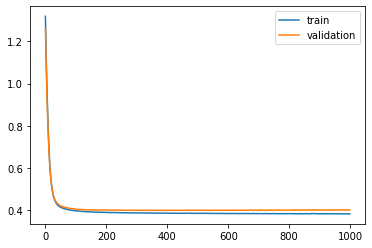

(10096, 1)
Entire process took:  464.28074169158936


In [10]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

# LSTM 1000 epochs (last 957)
units = 4
batch_s = 4096
L2 = 0.007298684687678438# 0.01 #0.005792049415665091

#Simple RNN 1000 epochs
units = 8 #16
batch_s = 16384 #8192
L2 = 0.01 #0.010994538313884483

start_time = time.time()

for f in range(1):#10
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_lstm = np.append(train2_x, train1_x, axis=0) 
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_lstm = np.append(train2_y, train1_y, axis=0)

    #config = tf.ConfigProto(log_device_placement = True)
    #config.gpu_options.visible_device_list='1'
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = Sequential()
        model.add(CuDNNLSTM(units, 
                            kernel_regularizer=regularizers.l2(L2),
                                    input_shape=(8, 182))) 
        model.add((Dense(1)))
        #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
        #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7) 
        model.compile(loss='mae', optimizer='adam')#'adam'
        val_weight = "val_weights" + str(f+1) + ".hdf5"
        val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
        history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                            epochs=1000, validation_split=0.1, 
                            callbacks=[val_checkpointer], 
                            verbose=2, 
                            shuffle=False) 
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
print(yhat_test.shape)
end_time = time.time()
print("Entire process took: ", time.time() - start_time)

In [13]:
print(yhat_test.shape)
yhat_v = scaler_y.inverse_transform(yhat_test)
yhat_df = pd.DataFrame(yhat_v)
print(yhat_df.shape)
yhat_df.columns = ["MEAN_TCHDL"]
feather.write_dataframe(yhat_df, "/home/whsu014/data/mean_TCHDL_LSTM_yhat_1000_new.feather")

(10096, 1)
(10096, 1)


In [25]:
print(mean_tchdl_test.shape)
y_df = pd.DataFrame(mean_tchdl_test)
y_df.columns = ["MEAN_TCHDL"]
#feather.write_dataframe(y_df, "/home/whsu014/data/mean_TCHDL_LSTM_y.feather")

(10096, 1)


## Analyse results

In [24]:
test_TCHDL_v = copy.deepcopy(view_1hot_df.iloc[(28*90000):, :].values)
print(test_TCHDL_v.shape)
print(test_TCHDL_v.shape[0]/28)

num_of_inds = test_TCHDL_v.shape[0]//28

mean_tchdl_list = []

for i in range(num_of_inds):
    ind_v = test_TCHDL_v[(i*28):((i+1)*28), :]
    tchdl = np.mean(ind_v[8:28, 14])
    mean_tchdl_list.append(tchdl)
y_v = np.array([mean_tchdl_list]).T
print(y_v.shape)

y_df = pd.DataFrame(y_v)
y_df.columns = ['MEAN_TCHDL']
#feather.write_dataframe(y_df, "/home/whsu014/data/mean_TCHDL_y.feather")

(282688, 189)
10096.0
(10096, 1)


In [2]:
#lstm_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_LSTM_yhat_200.feather")
#lstm_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_LSTM_yhat_300.feather")
#lstm_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_LSTM_yhat_500.feather")
#lstm_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_LSTM_yhat_1000.feather")
lstm_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_LSTM_yhat_1000_new.feather")
#lstm_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_LSTM_yhat_800.feather")
#lstm_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_LSTM_yhat.feather")
#rnn_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_SimpleRNN_yhat.feather")
#rnn_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_simpleRNN_yhat_500.feather")
rnn_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_SimpleRNN_yhat_1000.feather")

mlp_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_MLP_yhat_100.feather")
rr_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_Ridge_Regression_yhat.feather")
#y_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_y.feather")
#y2_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_LSTM_y.feather")
#print(y_df.equals(y2_df))
y_df = feather.read_dataframe("/home/whsu014/data/mean_TCHDL_y.feather")

print(lstm_df.shape)
print(rnn_df.shape)
print(mlp_df.shape)
print(rr_df.shape)
print(y_df.shape)

(10096, 1)
(10096, 1)
(10096, 1)
(10096, 1)
(10096, 1)


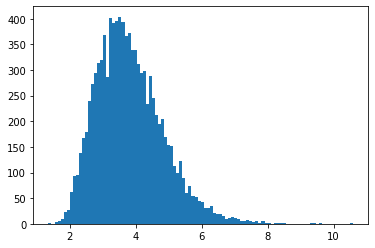

In [9]:
pyplot.hist(y_df.iloc[:, 0], bins=100)
pyplot.show()

In [3]:
print("LSTM:")
print("Mean absolute error:", 
      mean_absolute_error(y_df, lstm_df))
print("Mean squared error:", 
      mean_squared_error(y_df, lstm_df))
print("Root Mean squared error:", 
      math.sqrt(mean_squared_error(y_df, lstm_df)))
print("Simple RNN:")
print("Mean absolute error:", 
      mean_absolute_error(y_df, rnn_df))
print("Mean squared error:", 
      mean_squared_error(y_df, rnn_df))
print("Root Mean squared error:", 
      math.sqrt(mean_squared_error(y_df, rnn_df)))
print("MLP:")
print("Mean absolute error:", 
      mean_absolute_error(y_df, mlp_df))
print("Mean squared error:", 
      mean_squared_error(y_df, mlp_df))
print("Root Mean squared error:", 
      math.sqrt(mean_squared_error(y_df, mlp_df)))
print("Ridge Regression:")
print("Mean absolute error:", 
      mean_absolute_error(y_df, rr_df))
print("Mean squared error:", 
      mean_squared_error(y_df, rr_df))
print("Root Mean squared error:", 
      math.sqrt(mean_squared_error(y_df, rr_df)))

LSTM:
Mean absolute error: 0.45490394496474507
Mean squared error: 0.39583545115431146
Root Mean squared error: 0.6291545526770917
Simple RNN:
Mean absolute error: 0.4596831656639657
Mean squared error: 0.4033363800274931
Root Mean squared error: 0.6350876947536404
MLP:
Mean absolute error: 0.4650281045590079
Mean squared error: 0.43206936589952594
Root Mean squared error: 0.6573198353157509
Ridge Regression:
Mean absolute error: 0.47135615820264803
Mean squared error: 0.4209143357104279
Root Mean squared error: 0.6487791116477378


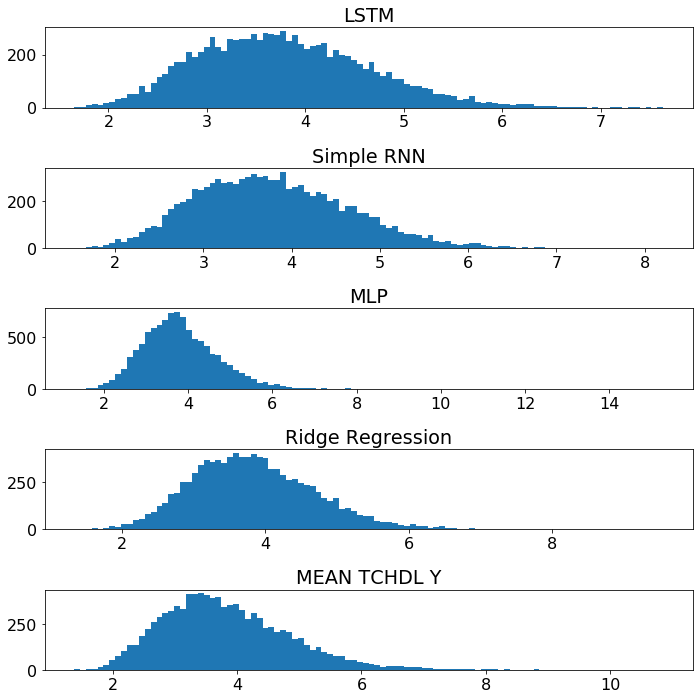

In [4]:
lstm_v = lstm_df.values
rnn_v = rnn_df.values
mlp_v = mlp_df.values
rr_v = rr_df.values
y_v = y_df.values

pyplot.rcParams.update({'font.size':16})
fig, axs = pyplot.subplots(5,1, figsize=(10, 10))
axs[0].hist(lstm_v[:, 0], bins=100)
axs[0].set_title("LSTM")
axs[1].hist(rnn_v[:, 0], bins=100)
axs[1].set_title("Simple RNN")
axs[2].hist(mlp_v[:, 0], bins=100)
axs[2].set_title("MLP")
axs[3].hist(rr_v[:, 0], bins=100)
axs[3].set_title("Ridge Regression")
axs[4].hist(y_v[:, 0], bins=100)
axs[4].set_title("MEAN TCHDL Y")
fig.tight_layout()
pyplot.show()

## Error comparison using two tail paired t-test 

In [6]:
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import shapiro

lstm_err = lstm_v - y_v
rnn_err = rnn_v - y_v
mlp_err = mlp_v - y_v
rr_err = rr_v - y_v
print("#########################################")
print("t-test on error")
#print(ttest_rel(lstm_err, rnn_err))
t, p = ttest_rel(lstm_err, rnn_err)
print("Mean TCHDL LSTM vs RNN \n t-statistics:", t[0], " p-value:",p[0])
#print(ttest_rel(lstm_err, mlp_err))
t, p = ttest_rel(lstm_err, mlp_err)
print("Mean TCHDL LSTM vs MLP \n t-statistics:", t[0], " p-value:",p[0])
#print(ttest_rel(lstm_err, rr_err))
t, p = ttest_rel(lstm_err, rr_err)
print("Mean TCHDL LSTM vs RR \n t-statistics:", t[0], " p-value:",p[0])
#print(ttest_rel(rnn_err, mlp_err))
t, p = ttest_rel(rnn_err, mlp_err)
print("Mean TCHDL RNN vs MLP \n t-statistics:", t[0], " p-value:",p[0])
#print(ttest_rel(rnn_err, rr_err))
t, p = ttest_rel(rnn_err, rr_err)
print("Mean TCHDL RNN vs RR \n t-statistics:", t[0], " p-value:",p[0])
#print(ttest_rel(mlp_err, rr_err))
t, p = ttest_rel(mlp_err, rr_err)
print("Mean TCHDL MLP vs RR \n t-statistics:", t[0], " p-value:",p[0])
'''
lstm_err = abs(lstm_v - y_v)
rnn_err = abs(rnn_v - y_v)
mlp_err = abs(mlp_v - y_v)
rr_err = abs(rr_v - y_v)
print("#########################################")
print("t-test on absolute error")
t, p = ttest_ind(lstm_err, rnn_err)
print("Mean TCHDL LSTM vs RNN \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(lstm_err, mlp_err)
print("Mean TCHDL LSTM vs MLP \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(lstm_err, rr_err)
print("Mean TCHDL LSTM vs RR \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(rnn_err, mlp_err)
print("Mean TCHDL RNN vs MLP \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(rnn_err, rr_err)
print("Mean TCHDL RNN vs RR \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(mlp_err, rr_err)
print("Mean TCHDL MLP vs RR \n t-statistics:", t[0], " p-value:",p[0])

lstm_err = (lstm_v - y_v)**2
rnn_err = (rnn_v - y_v)**2
mlp_err = (mlp_v - y_v)**2
rr_err = (rr_v - y_v)**2
print("#########################################")
print("t-test on squared error")
t, p = ttest_ind(lstm_err, rnn_err)
print("Mean TCHDL LSTM vs RNN \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(lstm_err, mlp_err)
print("Mean TCHDL LSTM vs MLP \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(lstm_err, rr_err)
print("Mean TCHDL LSTM vs RR \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(rnn_err, mlp_err)
print("Mean TCHDL RNN vs MLP \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(rnn_err, rr_err)
print("Mean TCHDL RNN vs RR \n t-statistics:", t[0], " p-value:",p[0])
t, p = ttest_ind(mlp_err, rr_err)
print("Mean TCHDL MLP vs RR \n t-statistics:", t[0], " p-value:",p[0])
'''

#########################################
t-test on error
Mean TCHDL LSTM vs RNN 
 t-statistics: -4.167369178440549  p-value: 3.1070447255907744e-05
Mean TCHDL LSTM vs MLP 
 t-statistics: -8.387925249714744  p-value: 5.609432729710849e-17
Mean TCHDL LSTM vs RR 
 t-statistics: -25.902567657291183  p-value: 2.7907749834897425e-143
Mean TCHDL RNN vs MLP 
 t-statistics: -6.409345718879309  p-value: 1.526718321231615e-10
Mean TCHDL RNN vs RR 
 t-statistics: -28.099876547741676  p-value: 2.4216919008160823e-167
Mean TCHDL MLP vs RR 
 t-statistics: -12.41593129951486  p-value: 3.864309692409353e-35


'\nlstm_err = abs(lstm_v - y_v)\nrnn_err = abs(rnn_v - y_v)\nmlp_err = abs(mlp_v - y_v)\nrr_err = abs(rr_v - y_v)\nprint("#########################################")\nprint("t-test on absolute error")\nt, p = ttest_ind(lstm_err, rnn_err)\nprint("Mean TCHDL LSTM vs RNN \n t-statistics:", t[0], " p-value:",p[0])\nt, p = ttest_ind(lstm_err, mlp_err)\nprint("Mean TCHDL LSTM vs MLP \n t-statistics:", t[0], " p-value:",p[0])\nt, p = ttest_ind(lstm_err, rr_err)\nprint("Mean TCHDL LSTM vs RR \n t-statistics:", t[0], " p-value:",p[0])\nt, p = ttest_ind(rnn_err, mlp_err)\nprint("Mean TCHDL RNN vs MLP \n t-statistics:", t[0], " p-value:",p[0])\nt, p = ttest_ind(rnn_err, rr_err)\nprint("Mean TCHDL RNN vs RR \n t-statistics:", t[0], " p-value:",p[0])\nt, p = ttest_ind(mlp_err, rr_err)\nprint("Mean TCHDL MLP vs RR \n t-statistics:", t[0], " p-value:",p[0])\n\nlstm_err = (lstm_v - y_v)**2\nrnn_err = (rnn_v - y_v)**2\nmlp_err = (mlp_v - y_v)**2\nrr_err = (rr_v - y_v)**2\nprint("#######################

## plot error

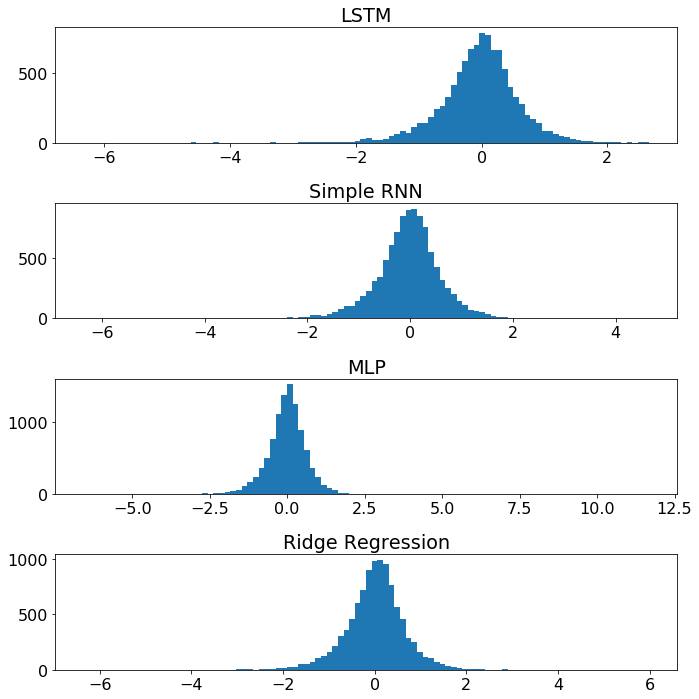

In [5]:
lstm_err = lstm_v - y_v
rnn_err = rnn_v - y_v
mlp_err = mlp_v - y_v
rr_err = rr_v - y_v

#lstm_err = abs(lstm_v - y_v)
#rnn_err = abs(rnn_v - y_v)
#mlp_err = abs(mlp_v - y_v)
#rr_err = abs(rr_v - y_v)

#lstm_err = (lstm_v - y_v)**2
#rnn_err = (rnn_v - y_v)**2
#mlp_err = (mlp_v - y_v)**2
#rr_err = (rr_v - y_v)**2

pyplot.rcParams.update({'font.size':16})
fig, axs = pyplot.subplots(4,1, figsize=(10, 10))
pyplot.title("Mean TCHDL Error")
axs[0].hist(lstm_err[:, 0], bins=100)
axs[0].set_title("LSTM")
axs[1].hist(rnn_err[:, 0], bins=100)
axs[1].set_title("Simple RNN")
axs[2].hist(mlp_err[:, 0], bins=100)
axs[2].set_title("MLP")
axs[3].hist(rr_err[:, 0], bins=100)
axs[3].set_title("Ridge Regression")
#axs[4].hist(y_v[:, 0], bins=100)
#axs[4].set_title("MEAN TCHDL Y")
fig.tight_layout()
pyplot.show()